In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

from scipy import stats
from scipy.stats import norm

import xgboost as xgb
import catboost as cb

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

import optuna

## Load Train/Test data

In [2]:
df_train = pd.read_csv('../Data/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../Data/house-prices-advanced-regression-techniques/test.csv')
print(f'df_train.shape = {df_train.shape}')
print(f'df_test.shape  = {df_test.shape}')

df_train.shape = (1460, 81)
df_test.shape  = (1459, 80)


### It is a good idea to combine train/test data to see if categorical features, missing values are consistent between the two datasets 

In [3]:
df_all = pd.concat([df_train, df_test])
print(f'df_all.shape = {df_all.shape}')

df_all.shape = (2919, 81)


## Exploratory data analysis

### Missing Values

In [4]:
total_missing = df_all.isnull().sum().sort_values(ascending=False)
total_present = df_all.shape[0] - total_missing
pct_missing   = np.round(100*(df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False),1)

missing_data = pd.concat([total_missing, total_present, pct_missing], axis=1, keys=['Total missing', 'Total present', '% Missing'])
missing_data.head(36)

,Total missing,Total present,% Missing
PoolQC,2909,10,99.7
MiscFeature,2814,105,96.4
Alley,2721,198,93.2
Fence,2348,571,80.4
SalePrice,1459,1460,50.0
FireplaceQu,1420,1499,48.6
LotFrontage,486,2433,16.6
GarageFinish,159,2760,5.4
GarageQual,159,2760,5.4
GarageCond,159,2760,5.4


* <b>PoolQC, MiscFeature, Alley</b> columns are overwhelmingly missing, so it makes sense to exclude them from the model as they are very unlikely to be helpful. 
* <b>Fence</b> column is also mostly missing, plus fence costs only around 10k to put up, so it cannot be a significant driver of house value. We'll drop it.
* <b>FireplaceQu</b> column has almost 50% values missing and also it is a categorical variable (6 categories). It's probably better to exclude it from the model as well (too many columns for the amount of data available). 
* <b>LotFrontage</b> column we will fill in with median values for the corresponding neighborhood. For most neighborhoods LotFrontage variability is only about 100 sq feet (see histogram below).
* <b>GarageType, GarageFinish, GarageQual, GarageCond</b> We'll replace missing values with None as those houses likely do not have garages.
* <b>GarageYrBlt, GarageArea, GarageCars</b> We'll replace missing data with 0 since no garage means no cars.
* <b>BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath</b> columns have missing values likely because house has no basement, so we'll fill with zeros.
* <b>BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2</b> are categorical basement-related features, for which NaN means that there is no basement. We'll fill with None.
* <b>MasVnrArea, MasVnrType</b> columns NAs meaning is most likely no masonry veneer for these houses. We'll fill with zeros for the area and None for type. 
* <b>MSZoning</b> has only 4 values missing. We will replace them with the most common value 'RL'.
* <b>Utilities</b> all values by one are "AllPub", hence we will drop this column.
* <b>Functional</b> here NA means 'Typ' per 'data_description.txt'
* <b>Electrical</b> has only 1 NA value; filling in with the most common 'SBrkr'.
* <b>KitchenQual</b> has only 1 NA value; filling in with the most common 'TA'.
* <b>Exterior1st, Exterior2nd</b> each has only 1 NA value; filling in with the most common 'VinylSd'.
* <b>SaleType</b> has only 1 NA value; filling in with the most common 'WD'.

### LotFrontage distributions by neighborhood

* This section is mean to justify that it makes sense to fill in NAs with median values by Neighborhood.

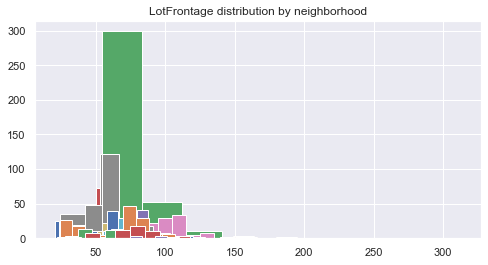

In [5]:
plt.figure(figsize=(8,4))
_ = df_all.groupby('Neighborhood')['LotFrontage'].hist()
_ = plt.title('LotFrontage distribution by neighborhood')

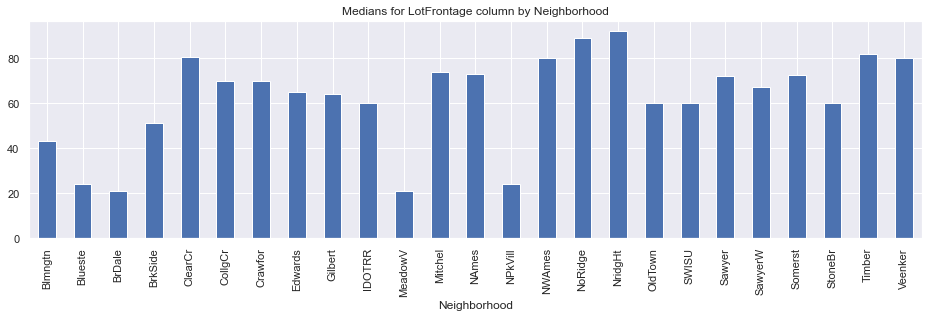

In [6]:
_ = df_all.groupby('Neighborhood').median()['LotFrontage'].plot.bar(figsize=(16,4), title='Medians for LotFrontage column by Neighborhood')

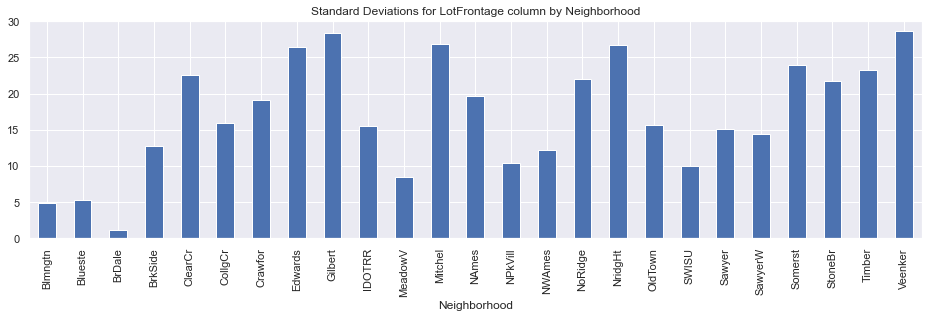

In [7]:
_ = df_all.groupby('Neighborhood').std()['LotFrontage'].plot.bar(figsize=(16,4), title='Standard Deviations for LotFrontage column by Neighborhood')

### EDA of categorical features where missing values are filled with the most common value

In [8]:
df_all['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [9]:
df_all['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [10]:
df_all['Electrical'].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [11]:
df_all['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

In [12]:
df_all['Exterior1st'].value_counts()

VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
Stone         2
AsphShn       2
CBlock        2
ImStucc       1
Name: Exterior1st, dtype: int64

In [13]:
df_all['Exterior2nd'].value_counts()

VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
Stucco       47
BrkFace      47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64

In [14]:
df_all['SaleType'].value_counts()

WD       2525
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

## Initial data transformation

* drop un-needed columns and fill in NAs as described above.
* drop Id column as well as it is not a feature.

In [15]:
def initial_data_preprocessing(df):
    
    df = df.drop(['Id'], axis=1)
    df = df.drop(['PoolQC', 'MiscFeature', 'Alley'], axis=1)
    df = df.drop(['Fence'], axis=1)
    df = df.drop(['FireplaceQu'], axis=1)
    df.loc[:,'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        df.loc[:, col] = df[col].fillna('None')
        
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        df.loc[:, col] = df[col].fillna(0)
    
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df.loc[:, col] = df[col].fillna(0)
        
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        df.loc[:, col] = df[col].fillna('None')
    
    df["MasVnrType"] = df["MasVnrType"].fillna("None")
    df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0]) # replacee with the most common type "RL"
    
    df = df.drop(['Utilities'], axis=1) # almost all values "AllPub", so not much value to have in a model
    
    df["Functional"] = df["Functional"].fillna("Typ") # Home functionality (Assume typical unless deductions are warranted)
    
    df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0]) 
    
    df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0]) 
    
    df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
    
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    return df

In [16]:
df_all = initial_data_preprocessing(df_all)

### Check train/test no longer have missing values

In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   LotConfig      2919 non-null   object 
 8   LandSlope      2919 non-null   object 
 9   Neighborhood   2919 non-null   object 
 10  Condition1     2919 non-null   object 
 11  Condition2     2919 non-null   object 
 12  BldgType       2919 non-null   object 
 13  HouseStyle     2919 non-null   object 
 14  OverallQual    2919 non-null   int64  
 15  OverallCond    2919 non-null   int64  
 16  YearBuilt      2919 non-null   int64  
 17  YearRemodAdd   2919 non-null   int64  
 18  RoofStyl

## Explore if some numerical variables are really categorical

In [18]:
df_all.select_dtypes(exclude='object').nunique().sort_values(ascending=False)

LotArea          1951
GrLivArea        1292
BsmtUnfSF        1135
1stFlrSF         1083
TotalBsmtSF      1058
BsmtFinSF1        991
SalePrice         663
2ndFlrSF          635
GarageArea        603
MasVnrArea        444
WoodDeckSF        379
BsmtFinSF2        272
OpenPorchSF       252
EnclosedPorch     183
LotFrontage       130
ScreenPorch       121
YearBuilt         118
GarageYrBlt       104
YearRemodAdd       61
MiscVal            38
LowQualFinSF       36
3SsnPorch          31
MSSubClass         16
TotRmsAbvGrd       14
PoolArea           14
MoSold             12
OverallQual        10
OverallCond         9
BedroomAbvGr        8
GarageCars          6
Fireplaces          5
YrSold              5
FullBath            5
KitchenAbvGr        4
BsmtFullBath        4
HalfBath            3
BsmtHalfBath        3
dtype: int64

In [19]:
for col in df_all.select_dtypes(exclude='object'):
    if df_all[col].nunique() < 31:
        print(f'{col} : {df_all[col].unique()}')

MSSubClass : [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40 150]
OverallQual : [ 7  6  8  5  9  4 10  3  1  2]
OverallCond : [5 8 6 7 4 2 3 9 1]
BsmtFullBath : [1. 0. 2. 3.]
BsmtHalfBath : [0. 1. 2.]
FullBath : [2 1 3 0 4]
HalfBath : [1 0 2]
BedroomAbvGr : [3 4 1 2 0 5 6 8]
KitchenAbvGr : [1 2 3 0]
TotRmsAbvGrd : [ 8  6  7  9  5 11  4 10 12  3  2 14 13 15]
Fireplaces : [0 1 2 3 4]
GarageCars : [2. 3. 1. 0. 4. 5.]
PoolArea : [  0 512 648 576 555 480 519 738 144 368 444 228 561 800]
MoSold : [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold : [2008 2007 2006 2009 2010]


In [20]:
numerical_categorical_features = ['MSSubClass', 'MoSold', 'YrSold'] 

In [21]:
def transform_pseudo_numerical_features_to_categorical(df):
    
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
    return df

In [22]:
df_all  = transform_pseudo_numerical_features_to_categorical(df_all)

## Additional features

In [23]:
def add_additional_features(df):
    
    df.loc[:,'TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    return df

In [24]:
df_all = add_additional_features(df_all)

## Look at top correlated numerical features

* We see that TotalSF is more correlated with SalePrice than either one of TotalBsmtSF, 1stFlrSF, and 2ndFlrSF. So, let's just keep TotalSF. Also helps avoid collinearity. 

In [25]:
df_all.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
TotalSF          0.782260
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.347806
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
GarageYrBlt      0.261366
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [26]:
def drop_selected_features(df):
    
    df = df.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis=1)
    
    return df

In [27]:
df_all = drop_selected_features(df_all)

## Let's look into potentially transforming skewed features into more normal looking ones

<div class="alert-block">
<b>Target variable:</b> SalePrice distribution appears to be lognormal-ish. Models typically benefit from normally distributed data, so we might want to log-transform our target variable.
</div>

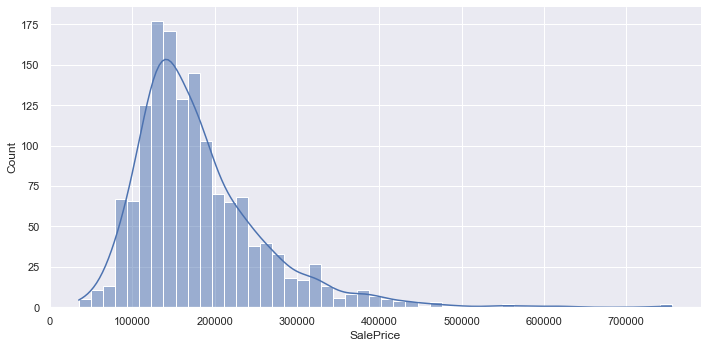

In [28]:
sns.displot(data=df_train, x="SalePrice", kde=True, aspect=2)

<div class="alert-block">
<b>Log-transformed target variable:</b> distribution appears to be a lot closer to a normal distribution.
</div>

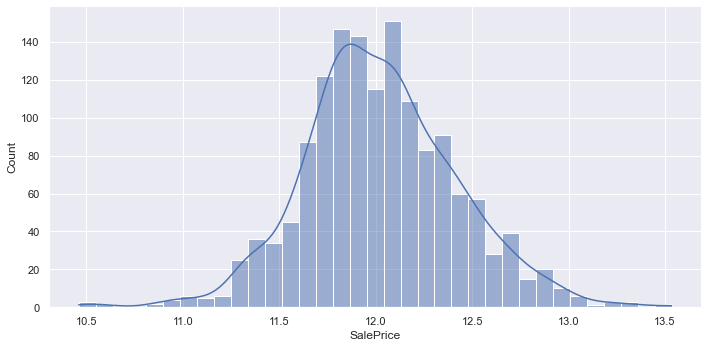

In [29]:
log_sale_price = np.log(df_train['SalePrice'])
sns.displot(data=log_sale_price, kde=True, aspect=2)

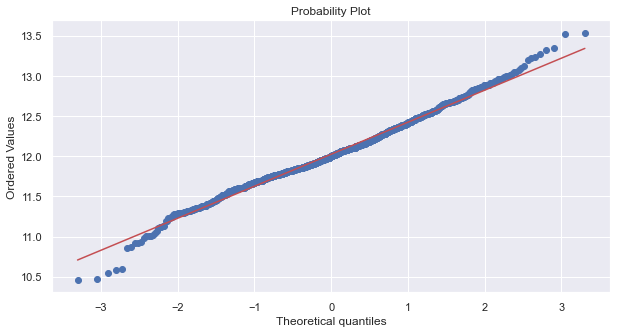

In [30]:
fig = plt.figure(figsize=(10,5))
res = stats.probplot(log_sale_price, plot=plt)

In [31]:
df_all.loc[:,'SalePrice'] = np.log(df_all['SalePrice'])

### To avoid looking at too many graphs, let us adopt a more systematic approach for finding candidates for log-transform

In [32]:
def get_numerical_features_skews(df):
    
    return pd.Series(
        stats.skew(df.select_dtypes(exclude='object')), 
        index=df.select_dtypes(exclude='object').columns
    ).sort_values(ascending=False)

In [33]:
get_numerical_features_skews(df_all)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
TotalSF           1.511479
LotFrontage       1.505704
BsmtFinSF1        1.425230
GrLivArea         1.269358
BsmtUnfSF         0.919339
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
SalePrice              NaN
dtype: float64

In [34]:
get_numerical_features_skews(np.log(df_all.select_dtypes(exclude='object') + 1))

PoolArea         14.998335
3SsnPorch         8.825256
LowQualFinSF      8.557690
MiscVal           5.213984
BsmtHalfBath      3.774762
KitchenAbvGr      3.520351
ScreenPorch       2.945905
BsmtFinSF2        2.462483
EnclosedPorch     1.961081
HalfBath          0.580692
MasVnrArea        0.537018
BsmtFullBath      0.425167
Fireplaces        0.237587
WoodDeckSF        0.158033
TotRmsAbvGrd      0.035107
GrLivArea         0.013188
OpenPorchSF      -0.041797
FullBath         -0.248646
TotalSF          -0.368434
YearRemodAdd     -0.458157
LotArea          -0.504751
BsmtFinSF1       -0.616632
YearBuilt        -0.626215
OverallQual      -0.647413
OverallCond      -0.746183
BedroomAbvGr     -0.983112
LotFrontage      -1.023606
GarageCars       -1.275584
BsmtUnfSF        -2.155206
GarageArea       -3.510452
GarageYrBlt      -3.925981
SalePrice              NaN
dtype: float64

<div class="alert-block">
<b>Plan of attack:</b> Skew of a normal distribution is zero, however, skew=0 does not imply distribution is normal. Still those features whose log-transform have skews closer to zero are our candidates for log-transform itself.
</div>

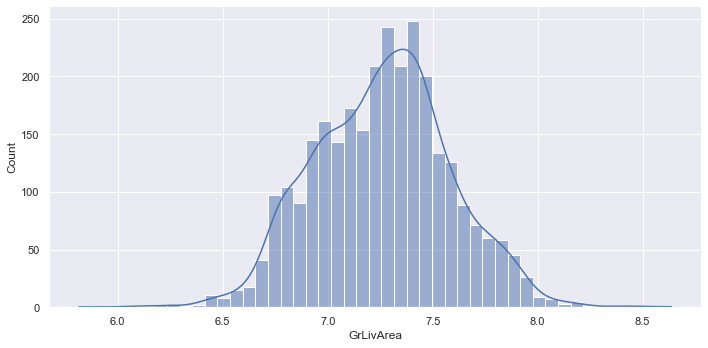

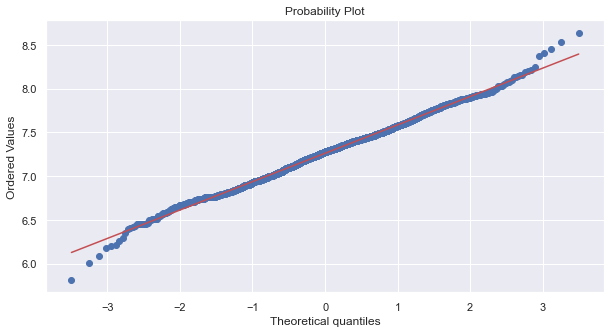

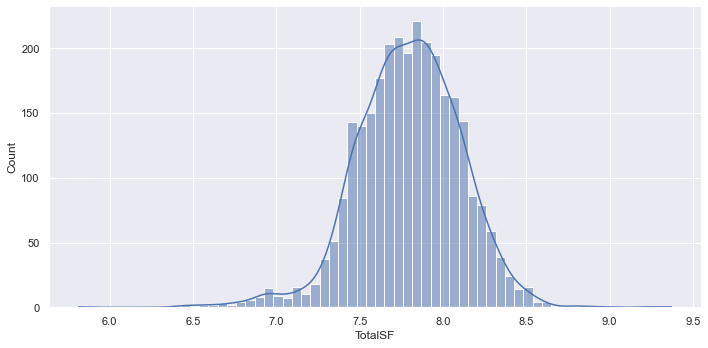

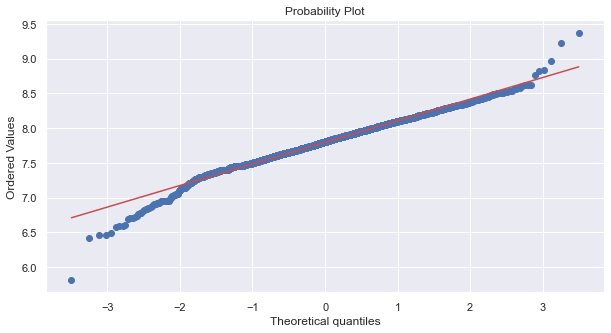

In [35]:
# We took all the features with skew of log close to zero and then ran this loop. In the end, it looked only three would really benefit from a log-transform
candidates_for_log_transform = ['GrLivArea', 'TotalSF']

for feature in candidates_for_log_transform:
    log_feature = np.log(df_all[feature] + 1)
    sns.displot(data=log_feature, kde=True, aspect=2)

    fig = plt.figure(figsize=(10,5))
    res = stats.probplot(log_feature, plot=plt)

In [36]:
def log_transform_features(df, features_to_log_transform):
    
    for feature in features_to_log_transform:
        df.loc[:,feature] = np.log(df[feature] + 1)

    return df

In [37]:
df_all = log_transform_features(df_all, candidates_for_log_transform)

## Some EDA of numerical features

#### Let's explore relationships of top 10 features by correlation to SalePrice

In [38]:
top_features_corr_to_sale_price = df_all.corr()['SalePrice'].sort_values(ascending=False).iloc[:10].index.tolist()

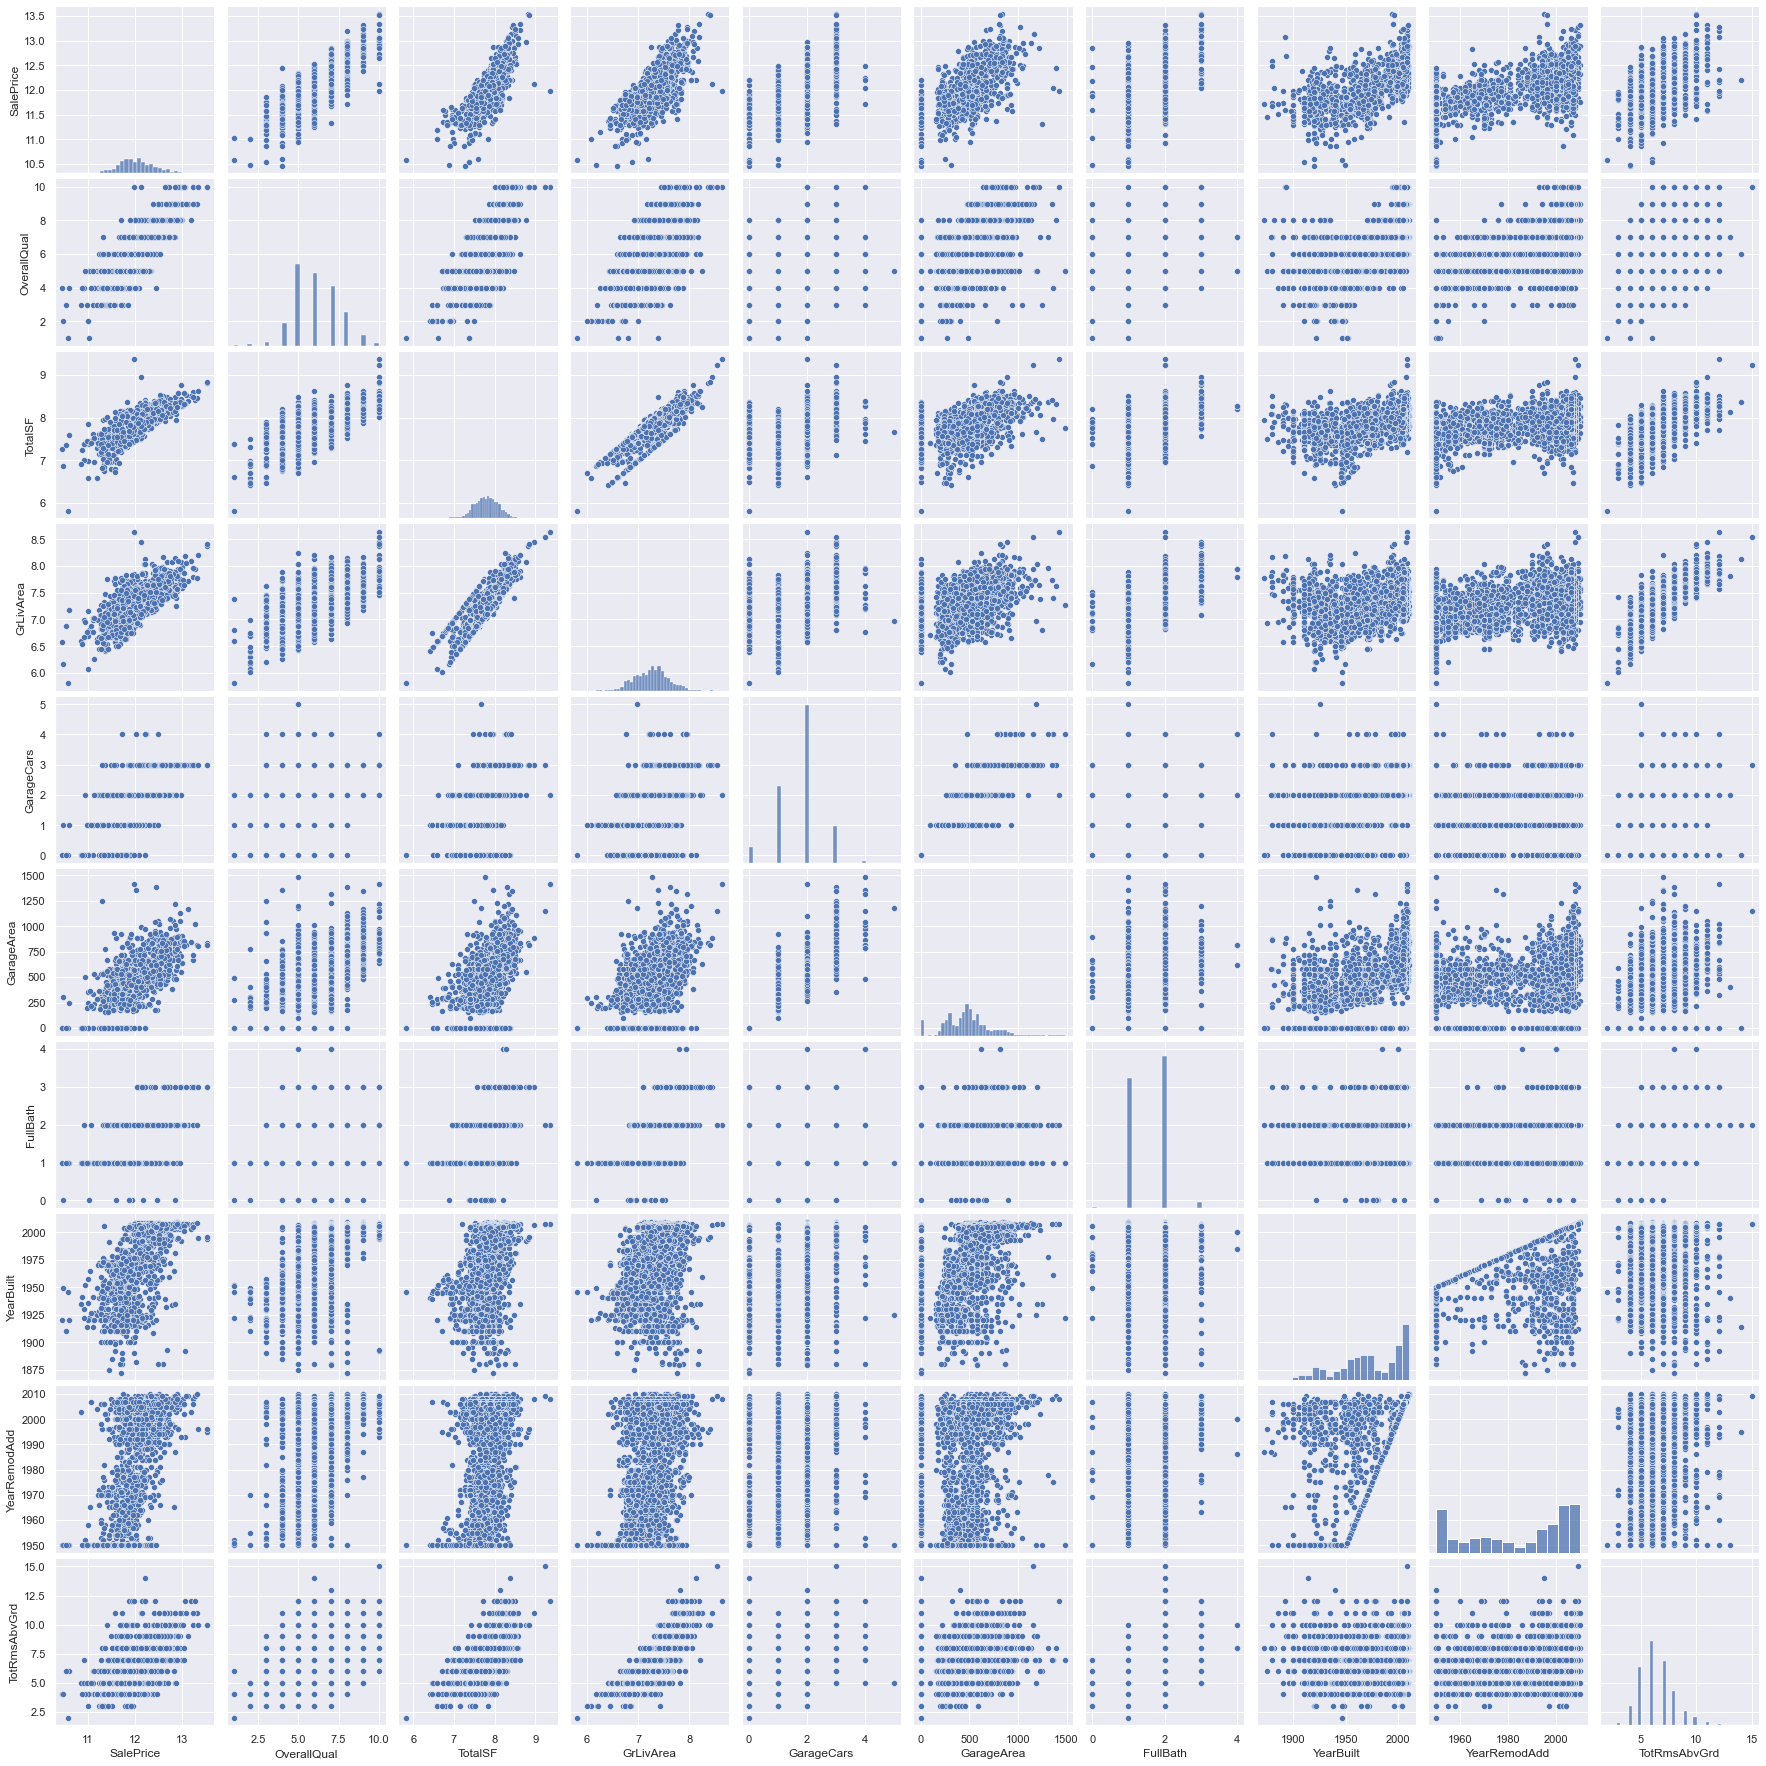

In [39]:
sns.pairplot(df_all[top_features_corr_to_sale_price])

## Convert all categorical features into one-hot encodings

In [40]:
df_all = pd.get_dummies(df_all)
print(f'df_all.shape = {df_all.shape}')

df_all.shape = (2919, 306)


## Modeling

In [41]:
X_train = df_all.iloc[:df_train.shape[0]].drop('SalePrice', axis=1)
y_train = df_all.iloc[:df_train.shape[0]]['SalePrice']
X_test  = df_all.iloc[df_train.shape[0]:].drop('SalePrice', axis=1)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape  = {X_test.shape}')

X_train.shape = (1460, 305)
y_train.shape = (1460,)
X_test.shape  = (1459, 305)


## Baseline models

### Linear Regression

In [42]:
def evaluate_linear_regression(n_splits=5, shuffle=True, random_state=42):

    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)    
    scores = []

    for train_index, test_index in kf.split(X_train):        
        model=LinearRegression()
        model.fit(X=X_train.loc[train_index], y=y_train.iloc[train_index])
        y_test_pred = model.predict(X_train.iloc[test_index])
        score = metrics.mean_squared_error(y_true=y_train[test_index], y_pred=y_test_pred, squared=False)
        scores.append(score)

    scores = np.array(scores)
    
    return np.mean(scores), np.std(scores), scores

In [43]:
lr_rmse, scores_std, scores = evaluate_linear_regression(
    n_splits=5,
    shuffle=True,
    random_state=42
)

print(f'mean score = {np.round(lr_rmse,5)} | scores std = {np.round(scores_std,5)} | scores = {np.round(scores,5)}')

mean score = 0.13829 | scores std = 0.02681 | scores = [0.12562 0.12326 0.18909 0.14014 0.11335]


### Un-tuned XGBoost

In [44]:
def evaluate_xgboost(n_splits=5, shuffle=True, random_state=42):

    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)    
    scores = []

    for train_index, test_index in kf.split(X_train):        
        model=xgb.XGBRegressor(random_state=42)
        model.fit(X=X_train.loc[train_index], y=y_train.iloc[train_index])
        y_test_pred = model.predict(X_train.iloc[test_index])
        score = metrics.mean_squared_error(y_true=y_train[test_index], y_pred=y_test_pred, squared=False)
        scores.append(score)

    scores = np.array(scores)
    
    return np.mean(scores), np.std(scores), scores

In [45]:
xgb_rmse, scores_std, scores = evaluate_xgboost(
    n_splits=5,
    shuffle=True,
    random_state=42
)

print(f'mean score = {np.round(xgb_rmse,5)} | scores std = {np.round(scores_std,5)} | scores = {np.round(scores,5)}')

mean score = 0.14422 | scores std = 0.01653 | scores = [0.15744 0.12824 0.1683  0.14158 0.12556]


### Un-tuned CatBoost

In [46]:
def evaluate_catboost(n_splits=5, shuffle=True, random_state=42):

    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)    
    scores = []

    for train_index, test_index in kf.split(X_train):        
        model=cb.CatBoostRegressor(verbose=0, random_state=42)
        model.fit(X=X_train.loc[train_index], y=y_train.iloc[train_index])
        y_test_pred = model.predict(X_train.iloc[test_index])
        score = metrics.mean_squared_error(y_true=y_train[test_index], y_pred=y_test_pred, squared=False)
        scores.append(score)

    scores = np.array(scores)
    
    return np.mean(scores), np.std(scores), scores

In [47]:
cb_rmse, scores_std, scores = evaluate_catboost(
    n_splits=5,
    shuffle=True,
    random_state=42
)

print(f'mean score = {np.round(cb_rmse,5)} | scores std = {np.round(scores_std,5)} | scores = {np.round(scores,5)}')

mean score = 0.12484 | scores std = 0.01724 | scores = [0.12844 0.10949 0.15509 0.1243  0.10689]


### Neural Network

In [48]:
def evaluate_neural_network(X, y, n_splits=5, shuffle=True, random_state=42, epochs=250):

    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)    
    scores = []
    
    for train_index, test_index in kf.split(X):
        
        model = models.Sequential()
        model.add(layers.Dense(256, input_dim=X_train.shape[1], activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1))

        model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())        
        
        early_stop = callbacks.EarlyStopping(monitor='val_loss',patience=10)
        
        model.fit(
            X[train_index], y[train_index], 
            validation_data=(X[test_index], y[test_index]),
            epochs=epochs, 
            verbose=0,
            callbacks=[early_stop]
        )
        
        y_test_pred = model.predict(X[test_index])
        score = metrics.mean_squared_error(y_true=y[test_index], y_pred=y_test_pred, squared=False)
        scores.append(score)

    scores = np.array(scores)
    
    return np.mean(scores), np.std(scores), scores

In [49]:
tf.random.set_seed(42)

scaler = MinMaxScaler()
X = scaler.fit_transform(X_train)

nn_rmse, scores_std, scores = evaluate_neural_network(
    X=X,
    y=y_train,
    n_splits=5,
    shuffle=True,
    random_state=42, 
    epochs=350
)

print(f'mean score = {np.round(nn_rmse,5)} | scores std = {np.round(scores_std,5)} | scores = {np.round(scores,5)}')

mean score = 0.16202 | scores std = 0.01846 | scores = [0.15319 0.14907 0.1941  0.17059 0.14315]


### CatBoost appears to be the winner

* GBTs typically perform better on tabular data, when properly tuned. 
* It's not surprising for the CatBoost to be the winner here (as opposed to XGBoost) as it is especially optimized for having categorical variables in a dataset, which we have a plenty of. 

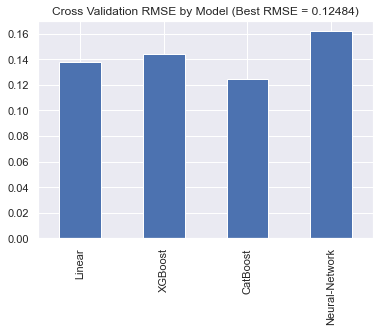

In [50]:
RMSEs = [lr_rmse, xgb_rmse, cb_rmse, nn_rmse]
_ = pd.Series(RMSEs, index=['Linear', 'XGBoost', 'CatBoost', 'Neural-Network']).plot.bar(title=f'Cross Validation RMSE by Model (Best RMSE = {np.round(min(RMSEs),5)})')

## Hyperparameters optimization with Optuna

* Let's try to build an even better CatBoost model.

In [51]:
def objective(trial, n_splits=5, shuffle=True, random_state=42, get_info=False):
    
    param = {        
        'verbose': 0,
        'random_state': 42,
        'loss_function': 'RMSE',
        'task_type': 'GPU',
        'iterations': trial.suggest_int('iterations', 10, 1000, 10),
        'depth': trial.suggest_int('depth', 1, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'random_strength': trial.suggest_uniform('random_strength', 1e-9, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 30),
    }
    
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)    
    
    scores = []
    models = []

    i = 0
    
    for train_index, test_index in kf.split(X_train):        
        
        if i==0:
            val_actuals = np.zeros(shape=(X_train.iloc[test_index].shape[0], n_splits))
            val_predicted = np.zeros(shape=(X_train.iloc[test_index].shape[0], n_splits))
        
        model = cb.CatBoostRegressor(**param)  

        model.fit(
            X=X_train.loc[train_index], 
            y=y_train.iloc[train_index],
            eval_set=[(X_train.iloc[test_index], y_train.iloc[test_index])],
            early_stopping_rounds=200,
            verbose=0
        )

        y_test_pred = model.predict(X_train.iloc[test_index])
        
        score = metrics.mean_squared_error(y_true=y_train[test_index], y_pred=y_test_pred, squared=False)
        
        scores.append(score)
        models.append(model)
        val_actuals[:,i] = y_train[test_index]
        val_predicted[:,i] = y_test_pred
        i += 1
        

    scores = np.array(scores)
    
    if get_info:
        
        info = {
            'rmse_mean': np.mean(scores), 
            'rmse_std' : np.std(scores), 
            'rmse_scores': scores, 
            'models': models,
            'val_actuals': val_actuals,
            'val_predicted': val_predicted
        }
        
        return info
    else:
        return np.mean(scores)

In [52]:
study = optuna.create_study(direction='minimize', study_name='house_prices_advanced_regression')
study.optimize(objective, n_trials=200, show_progress_bar=True)

[I 2022-05-20 15:28:58,709] A new study created in memory with name: house_prices_advanced_regression
C:\Users\yurit\anaconda3\envs\ml\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-05-20 15:29:07,710] Trial 0 finished with value: 0.13747896902426288 and parameters: {'iterations': 230, 'depth': 7, 'learning_rate': 0.5776273267219509, 'random_strength': 5.903202421444577, 'bagging_temperature': 0.16702902596324287, 'border_count': 142, 'l2_leaf_reg': 20.903459683756804}. Best is trial 0 with value: 0.13747896902426288.
[I 2022-05-20 15:29:32,300] Trial 1 finished with value: 0.13169754073139367 and parameters: {'iterations': 950, 'depth': 2, 'learning_rate': 0.15455165162861934, 'random_strength': 5.860195267269778, 'bagging_temperature': 0.8976854758359218, 'border_count': 17, 'l2_leaf_reg': 0.8422522001834425}. Best is trial 1 with value: 0.13169754073139367.
[I 2022-05-20 15:29:38,030] Trial 2 finished with value: 0.16320646443466796 and parameters: {'iterations': 90, 'depth': 7, 'learning_rate': 0.7182281318438991, 'random_strength': 2.222839912366609, 'bagging_temperature': 0.7149559619029221, 'border_count': 85, 'l2_leaf_reg': 0.21870554123543215}. Be

### Best score and best hyperparameters

In [53]:
print(f'Our best RMSE of {np.round(study.best_value,5)} on a tuned CatBoost model is a little better than our initial RMSE of {np.round(cb_rmse,5)}')

Our best RMSE of 0.1228 on a tuned CatBoost model is a little better than our initial RMSE of 0.12484


In [54]:
study.best_params

{'iterations': 470,
 'depth': 5,
 'learning_rate': 0.09278618690137062,
 'random_strength': 2.5432538037793635,
 'bagging_temperature': 0.053962863038826504,
 'border_count': 137,
 'l2_leaf_reg': 6.9842632411238625}

## Get best models out of the study

In [55]:
info = objective(optuna.trial.FixedTrial(study.best_params), get_info=True)

## Examine consistency of predictions vs. actuals across the folds

In [56]:
val_actuals = info['val_actuals']
val_predict = info['val_predicted']

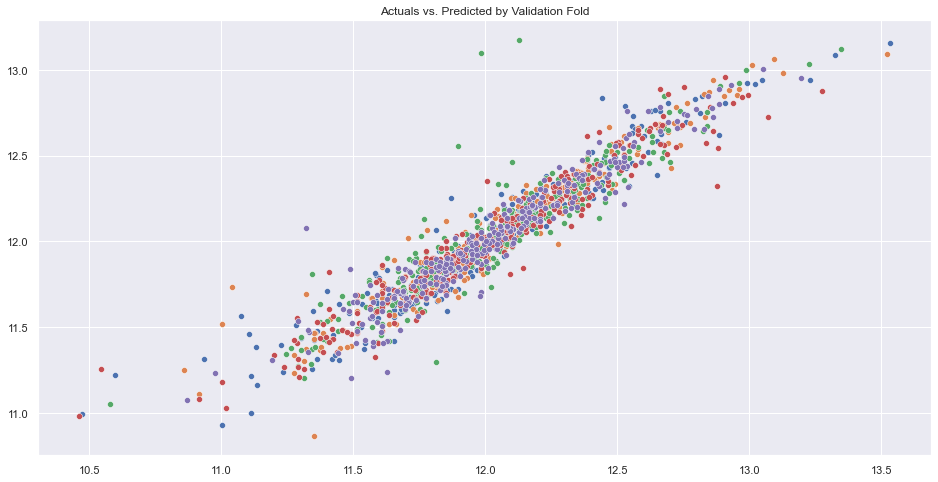

In [57]:
plt.figure(figsize=(16,8))
for i in range(val_actuals.shape[1]):    
    sns.scatterplot(x=val_actuals[:,i], y=val_predict[:,i])
_ = plt.title('Actuals vs. Predicted by Validation Fold')

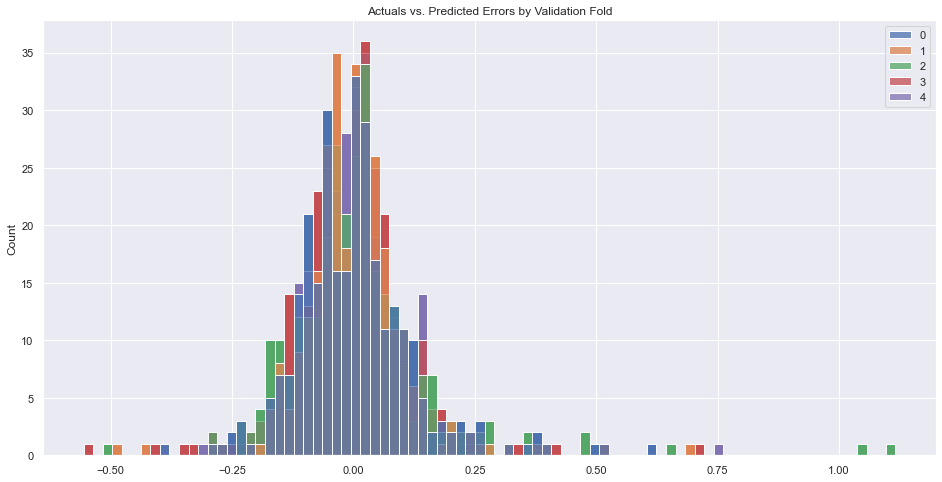

In [58]:
plt.figure(figsize=(16,8))
for i in range(val_actuals.shape[1]):    
    sns.histplot(val_predict - val_actuals)
_ = plt.title('Actuals vs. Predicted Errors by Validation Fold')

In [59]:
mse = 0
for i in range(val_actuals.shape[1]):    
    mse += metrics.mean_squared_error(y_true=val_actuals[:,i], y_pred=val_predict[:,i])
print(f'Combined Validation RMSE = {np.round(np.sqrt(mse/val_actuals.shape[1]),5)}')

Combined Validation RMSE = 0.12382


## MDI Feature importances

* Let's plot average feature importances across the models of the best trial.

In [60]:
best_models = info['models']

feature_importances = pd.Series(dtype=float, index=X_train.columns)

for i in range(len(best_models)):    
    model = best_models[i]
    if i==0:
        feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    else:
        feature_importances += pd.Series(model.feature_importances_, index=X_train.columns)
        
feature_importances /= len(best_models)

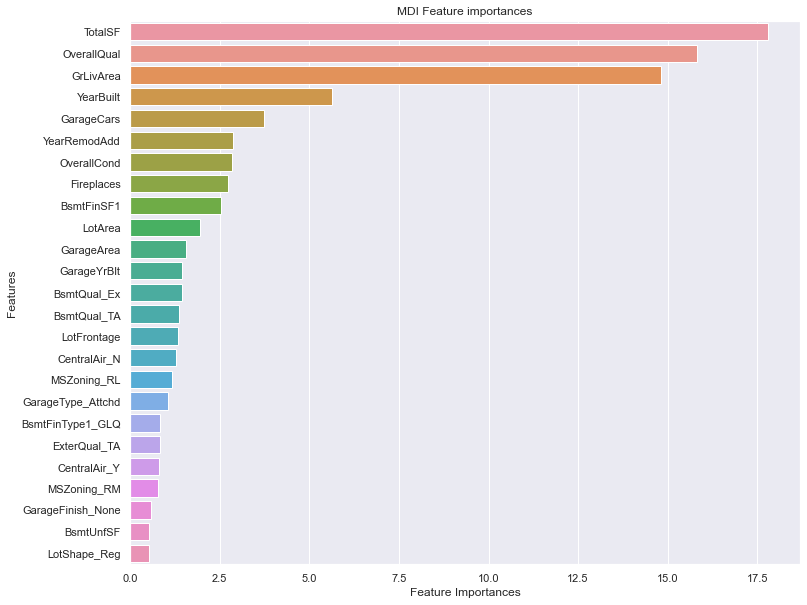

In [61]:
top_important_features = feature_importances.sort_values(ascending=False).iloc[:25]

top_important_features = pd.DataFrame({'Features': top_important_features.index, 'Feature Importances': top_important_features.values})

_ = plt.figure(figsize=(12,10))
_ = sns.barplot(data=top_important_features, x='Feature Importances', y='Features')
_ = plt.title('MDI Feature importances')

## MDA Feature importances

In [62]:
best_models = info['models']

In [63]:
def best_models_bag(X):
    
    predictions = {}

    for i in range(len(best_models)):
        model = best_models[i]
        predictions[f'fold_{i+1}'] = model.predict(X)

    predictions = pd.DataFrame(predictions)
    predictions['folds_mean'] = predictions.mean(axis=1)

    return predictions['folds_mean']

In [64]:
def MDA(regressor, X, y):
    
    y_pred = regressor(X)
    rmse = metrics.mean_squared_error(
        y_true=y,
        y_pred=y_pred,
        squared=False
    )
    
    feat_importances = pd.Series(index=X.columns, dtype=float)
    
    for feature in feat_importances.index:
        
        X_ = X.copy(deep=True)
        
        np.random.shuffle(X_[feature].values)
        
        y_pred_new = regressor(X_)
        rmse_new = metrics.mean_squared_error(
            y_true=y,
            y_pred=y_pred_new,
            squared=False
        )
        
        feat_importances.loc[feature] = np.abs(rmse_new - rmse)
        
    return feat_importances

In [65]:
feat_MDA_importances = MDA(best_models_bag, X_train, y_train)

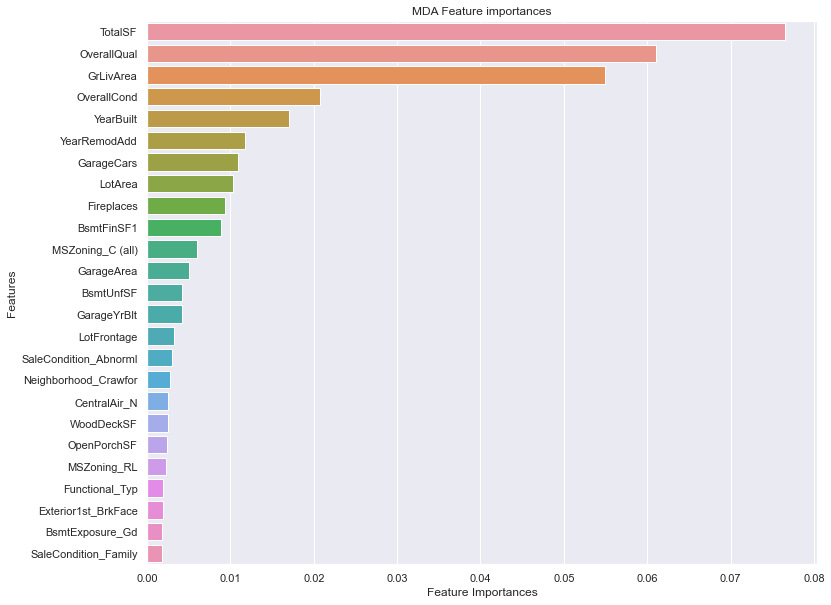

In [66]:
top_MDA_importances = feat_MDA_importances.sort_values(ascending=False).iloc[:25]

top_MDA_importances = pd.DataFrame({'Features': top_MDA_importances.index, 'Feature Importances': top_MDA_importances.values})

_ = plt.figure(figsize=(12,10))
_ = sns.barplot(data=top_MDA_importances, x='Feature Importances', y='Features')
_ = plt.title('MDA Feature importances')

## Calculate predictions on the test set and write to a submission file

* The final prediction is an average of models constructed across folds in the best trial.

In [67]:
test_predictions = best_models_bag(X_test)

test_predictions = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': np.exp(test_predictions)})

test_predictions.to_csv('submission.csv', index=False)

# Analysis of model weakness

* Tree models are typically not good at extrapolating. They can only do constant extrapolation due to the nature of how they are constructed. 
* Tree models are also hard to interpret. However, there are tools developed for 'local interpretability' such as SHAP values, for example.
* More work could be done on features selection and features engineering. 
* Could have done more work on identifying and removing outliers in the data.
* We could also explore blending and stacking different models.